# Kalman Filter
The code below is an implementation of a stationary Kalman filter. 
It estimates the system state from measurements and provides tools for system simulation and predictive control design

In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are

class Stationary_KalmanFilter:
    def __init__(self, A, B, C, Q, R, x):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.Z = solve_discrete_are(self.A.T, self.C.T, self.Q, self.R) - self.Q
        self.P = np.linalg.solve(self.A, np.linalg.solve(self.A, self.Z.T).T)
        self.K = self.Z @ self.C.T @ np.linalg.inv(self.C @ self.Z @ self.C.T + self.R)
        self.x = x

    def update(self, y, u=None):
        I = np.identity(self.A.shape[0])
        if u is None:
            u = np.zeros((self.C.shape[0], 1))
        self.x = (I - self.K @ self.C) @ (self.A @ self.x + self.B @ u) + self.K @ y
        return self.x

    def sim(self, x, u=np.zeros((1, 1))):
        x_t = self.A @ x + self.B @ u + np.random.multivariate_normal(np.zeros(self.Q.shape[0]), self.Q).reshape(-1, 1)
        y_t = self.C @ x_t + np.random.multivariate_normal(np.zeros(self.R.shape[0]), self.R).reshape(-1, 1)
        return x_t, y_t

    def Tau_yu(self, N):
        m = self.C.shape[0]
        D = np.zeros((m, m))
        blocks = [[None for _ in range(N)] for _ in range(N)]

        for i in range(N):
            for j in range(N):
                if j >= i:
                    blocks[i][j] = D
                else:
                    A_power = np.linalg.matrix_power(self.A, i - j - 1)
                    blocks[i][j] = self.C @ A_power @ self.B

        rows = [np.hstack(row) for row in blocks]
        full_matrix = np.vstack(rows)
        return full_matrix

    def Phi_yx(self, x0, N):
        x_vecs = [x0]
        for i in range(1, N):
            x_vecs.append(self.A @ x_vecs[i - 1])
        y_vecs = [self.C @ x for x in x_vecs]
        return np.vstack(y_vecs)

    def get_U(self, x0, N, W, Q_y=None, Q_u=None):
        tau_yu = self.Tau_yu(N)
        phi_yx = self.Phi_yx(x0, N)

        if Q_y is None:
            Q_y = np.eye(tau_yu.shape[0])
        elif np.isscalar(Q_y):
            Q_y = Q_y * np.eye(tau_yu.shape[0])

        if Q_u is None:
            Q_u = np.eye(tau_yu.shape[1])
        elif np.isscalar(Q_u):
            Q_u = Q_u * np.eye(tau_yu.shape[1])

        H = tau_yu.T @ Q_y @ tau_yu + Q_u
        rhs = tau_yu.T @ Q_y @ (phi_yx - W)

        return -np.linalg.solve(H, rhs)



# Question 1.1

In [64]:
A = np.array([[0.7901, 0.0238, 0.1667, 0.0081],
              [0.0238, 0.7901, 0.0081, 0.1667],
              [0.1667, 0.0081, 0.7236, 0.0014],
              [0.0081, 0.1667, 0.0014, 0.7236]])

B = np.array([[1.4459, 0.0622],
              [0.0622, 1.4459],
              [13.3615, 0.0077],
              [0.0077, 13.3615]])
# R1 
Q = np.array([[8.0209, 0.2260, 1.5334, 0.0812],
               [0.2260, 8.0209, 0.0812, 1.5334],
               [1.5334, 0.0812, 7.4082, 0.0172],
               [0.0812, 1.5334, 0.0172, 7.4082]])

C = np.array([[1,0,0,0],
              [0,1,0,0]])

# R2
R = np.identity(2)

x0 = np.array([[0],[0],[0],[0]])
u = np.array([[0],[0]])

kf = Stationary_KalmanFilter(A, B, C, Q, R, x0)


N = 200
x_true = []
y_meas = []
x_est = []

np.random.seed(42)
for i in range(N):
    if i != 0:
        x_t, y_t = kf.sim(x = x_t, u=u)
    else:
        x_t, y_t = kf.sim(x = x0, u=u)
    kf.update(y_t)

    x_true.append(x_t)
    y_meas.append(y_t)
    x_est.append(kf.x)

x_true = np.array(x_true).squeeze()
y_meas = np.array(y_meas).squeeze()
x_est = np.array(x_est).squeeze()


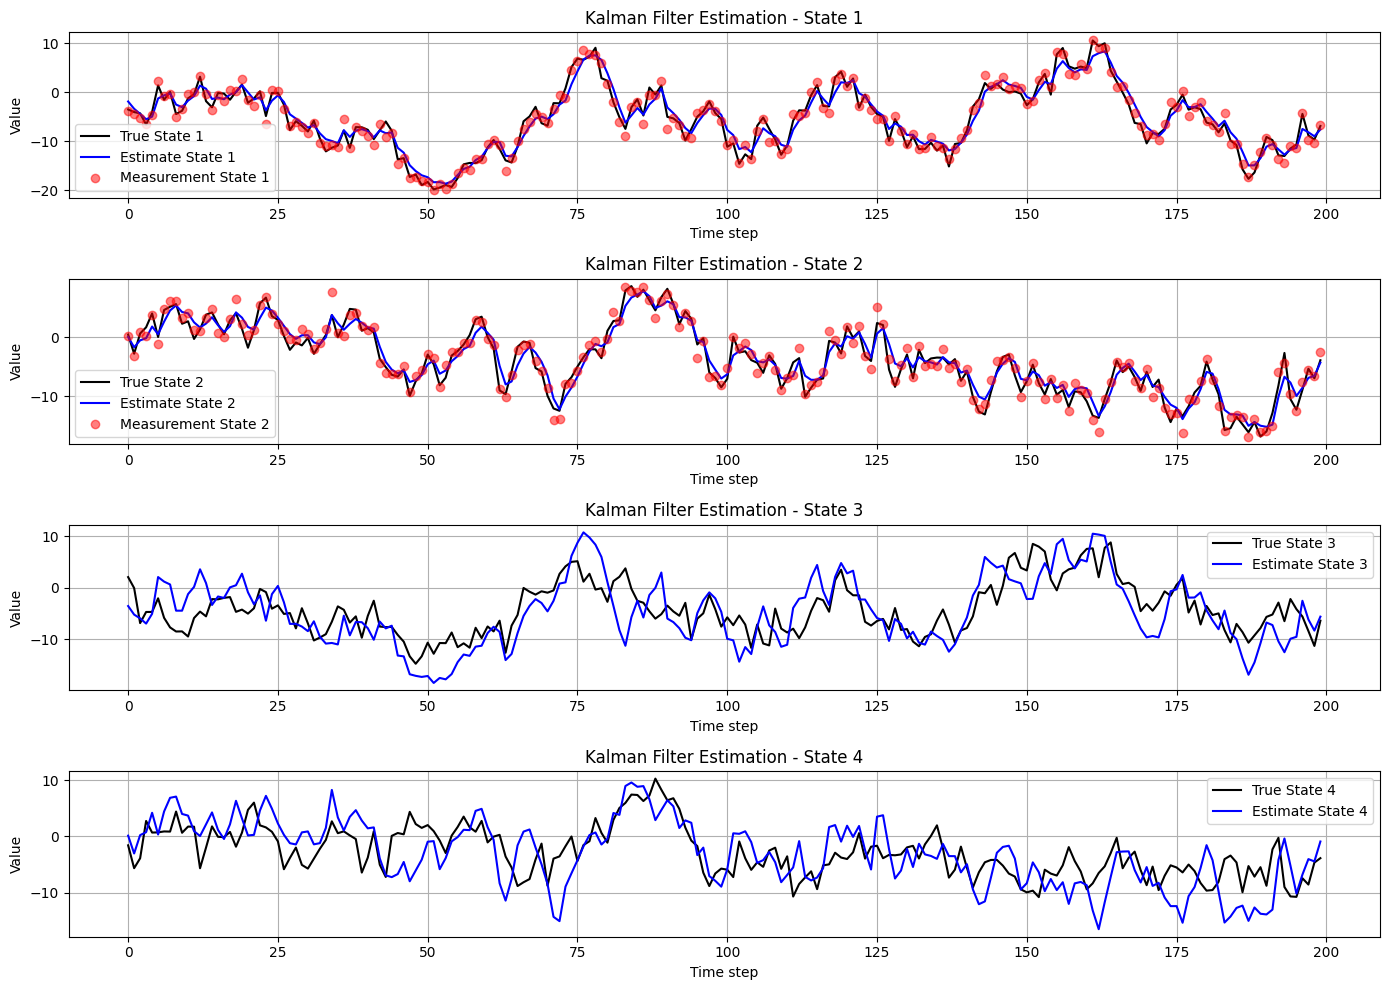

In [65]:
import matplotlib.pyplot as plt

time = np.arange(N)

plt.figure(figsize=(14, 10))

state_labels = ['State 1', 'State 2', 'State 3', 'State 4']
colors = ['black', 'black', 'black', 'black']
estimate_colors = ['blue', 'blue', 'blue', 'blue']
measurement_colors = ['red', 'red']

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time, x_true[:, i], label=f'True {state_labels[i]}', color=colors[i])
    plt.plot(time, x_est[:, i], label=f'Estimate {state_labels[i]}', color=estimate_colors[i])
    if i < 2:  # Only the first two states are measured
        plt.plot(time, y_meas[:, i], 'o', label=f'Measurement {state_labels[i]}', color=measurement_colors[i], alpha=0.5)
    plt.ylabel('Value')
    plt.xlabel('Time step')
    plt.title(f'Kalman Filter Estimation - {state_labels[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/Question1.png')
plt.show()


# Question 1.2

Q_y=0.01, N=6
Q_y=0.01, N=11
Q_y=0.01, N=16
Q_y=1, N=6
Q_y=1, N=11
Q_y=1, N=16
Q_y=100, N=6
Q_y=100, N=11
Q_y=100, N=16


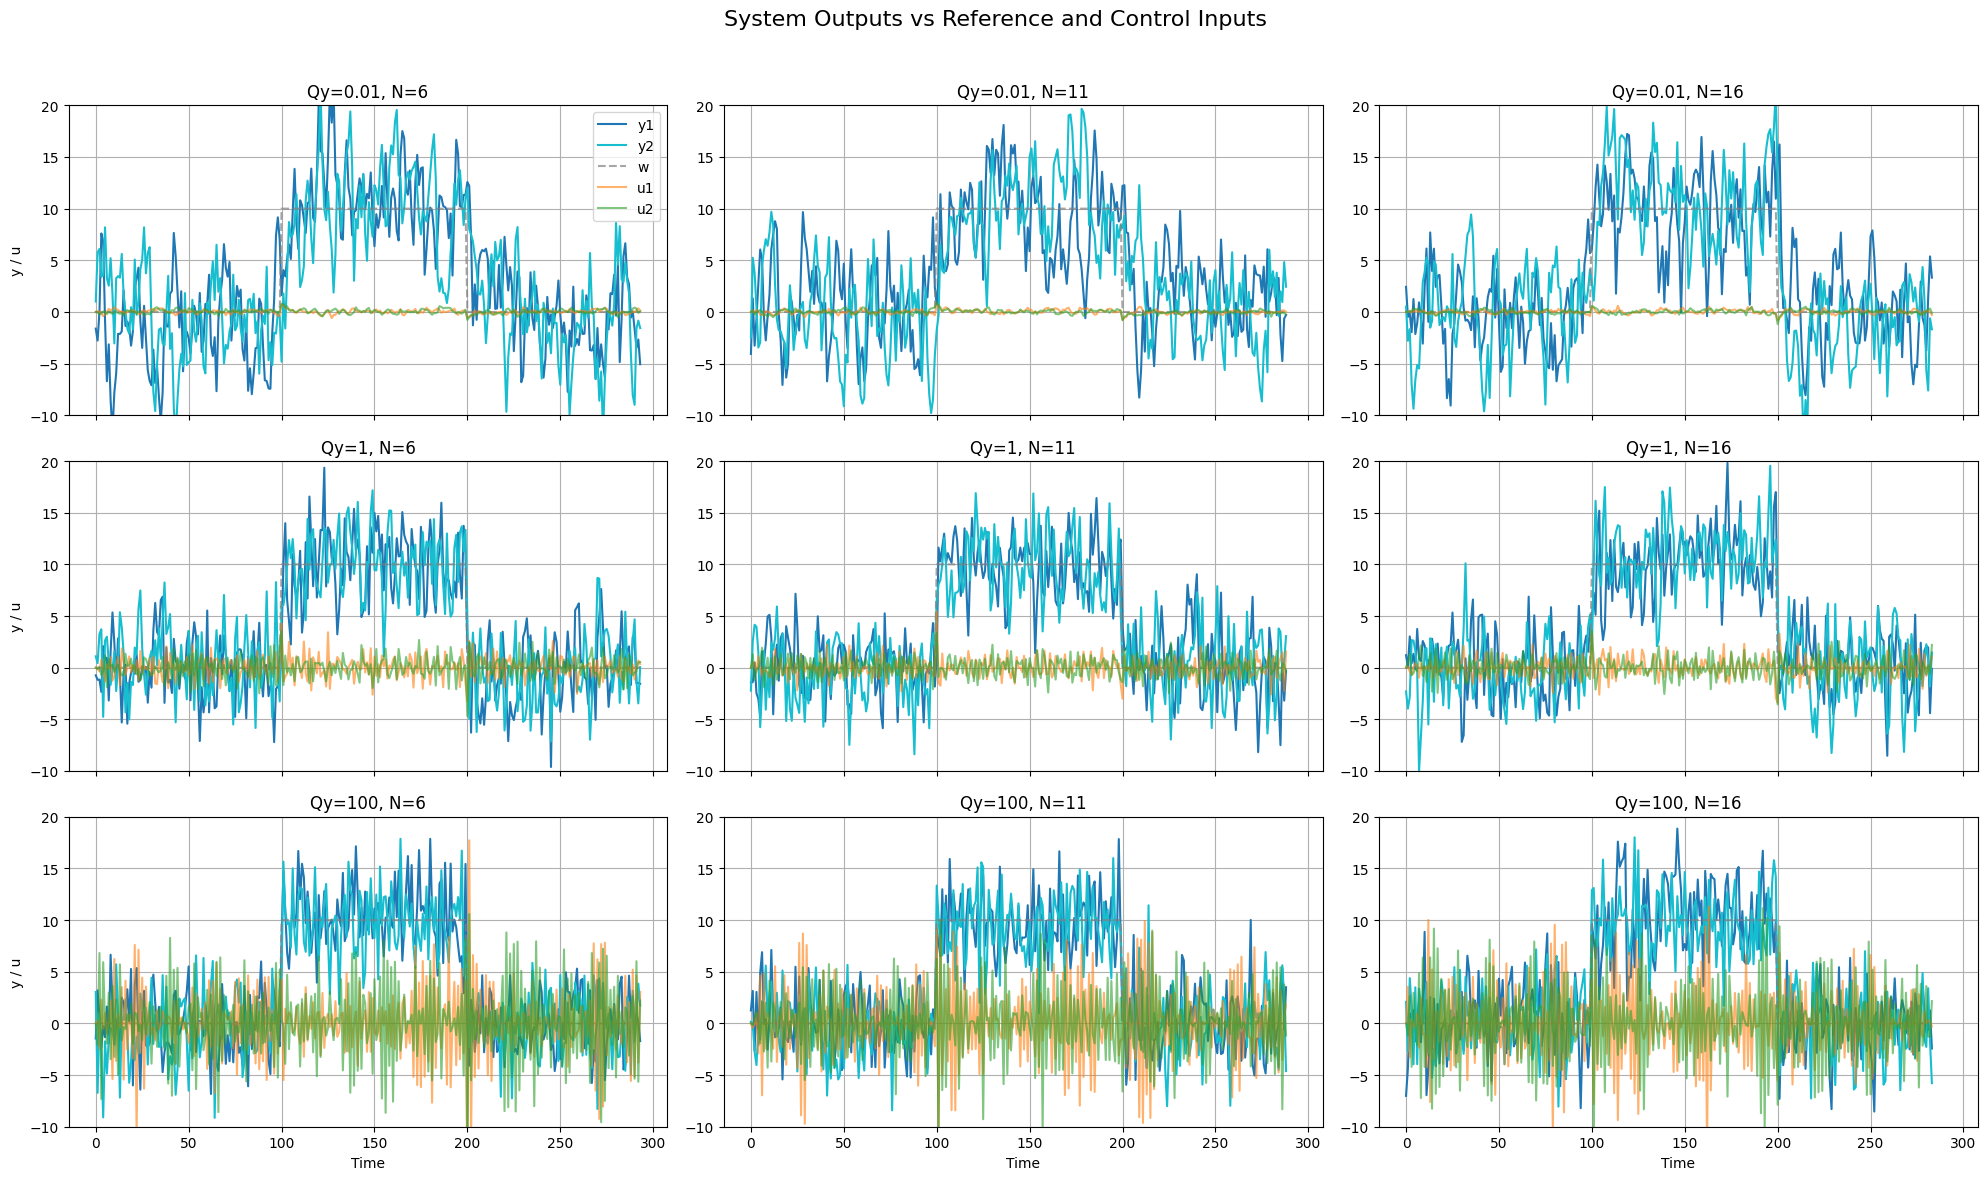

In [66]:
# System definition
x0 = np.zeros((4, 1))
kf = Stationary_KalmanFilter(A, B, C, Q, R, x0)

steps = 300

import matplotlib.pyplot as plt

Q_y_vals = [0.01, 1, 100]
N_vals = list(range(6, 20, 5))  # [6, 11, 16]
fig, axs = plt.subplots(len(Q_y_vals), len(N_vals), figsize=(20, 12), sharex=True)
fig.suptitle("System Outputs vs Reference and Control Inputs", fontsize=16)
for i, Q_y_val in enumerate(Q_y_vals):
    for j, N in enumerate(N_vals):
        print(f"Q_y={Q_y_val}, N={N}")

        # Simulation
        x = np.copy(x0)
        x_hist, y_hist, u_hist, w_hist = [], [], [], []

        for t in range(steps - N):
            w = 1.0 * ((t // 100) % 2) * 10
            W = np.tile([[w], [w]], (N, 1))
            U = kf.get_U(x, N, W, Q_y=Q_y_val, Q_u=1)
            u_t = U[:2]
            x, y = kf.sim(x, u_t)
            x_hist.append(x.flatten())
            y_hist.append(y.flatten())
            u_hist.append(u_t.flatten())
            w_hist.append([w, w])

        # Convert to arrays
        x_hist = np.array(x_hist)
        y_hist = np.array(y_hist)
        u_hist = np.array(u_hist)
        w_hist = np.array(w_hist)
        T = y_hist.shape[0]

        # Plot both output and input in same subplot
        ax = axs[i, j]
        ax.plot(y_hist[:, 0], label="y1", color='tab:blue')
        ax.plot(y_hist[:, 1], label="y2", color='tab:cyan')
        ax.plot(w_hist[:T, 0], '--', label="w", color='gray', alpha=0.7)
        ax.plot(u_hist[:, 0], label="u1", color='tab:orange', alpha=0.6)
        ax.plot(u_hist[:, 1], label="u2", color='tab:green', alpha=0.6)
        ax.set_title(f"Qy={Q_y_val}, N={N}")
        ax.set_ylim(-10,20)
        ax.grid(True)
        if i == len(Q_y_vals)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("y / u")
        if i == 0 and j == 0:
            ax.legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave room for suptitle
plt.savefig('Figures/Question2.png')
plt.show()


# Question 1.3

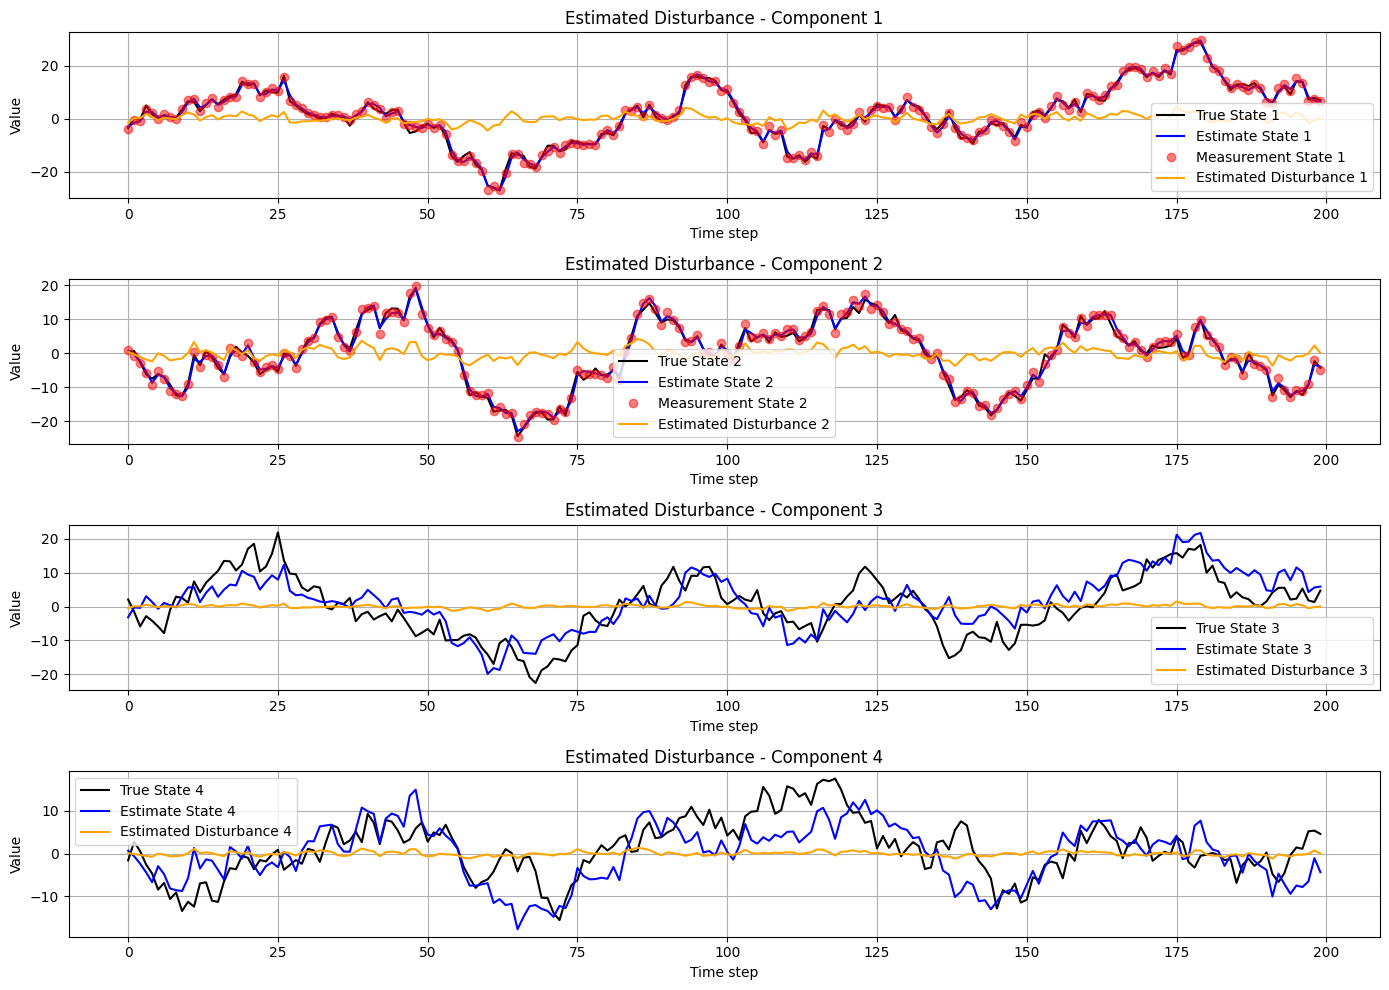

In [67]:
I = np.identity(4)
kappa = I*0.8
A_13 = np.block([
    [A, I],
    [np.zeros(A.shape), kappa]
])
#print(A_13)

B_13 = np.block([
    [B],
    [np.zeros(B.shape)]
])
#print(B_13)

C_13 = np.block([C,np.zeros_like(C)])
#print(C_13)

sigma_d = 1
Q_13 = np.block([[Q,np.zeros_like(Q)],
                 [np.zeros_like(A),I*sigma_d]])
#print(Q_13)

R_13 = R
# System definition
x0 = np.zeros((8, 1))
kf = Stationary_KalmanFilter(A_13, B_13, C_13, Q_13, R_13, x0)
N = 200
x_true = []
y_meas = []
x_est = []

np.random.seed(42)
for i in range(N):
    if i != 0:
        x_t, y_t = kf.sim(x = x_t, u=u)
    else:
        x_t, y_t = kf.sim(x = x0, u=u)
    kf.update(y_t)

    x_true.append(x_t)
    y_meas.append(y_t)
    x_est.append(kf.x)

x_true = np.array(x_true).squeeze()
y_meas = np.array(y_meas).squeeze()
x_est = np.array(x_est).squeeze()

time = np.arange(N)
state_labels = ['State 1', 'State 2', 'State 3', 'State 4']
colors = ['black', 'black', 'black', 'black']
estimate_colors = ['blue', 'blue', 'blue', 'blue']
measurement_colors = ['red', 'red']

plt.figure(figsize=(14, 10))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time, x_true[:, i], label=f'True {state_labels[i]}', color=colors[i])
    plt.plot(time, x_est[:, i], label=f'Estimate {state_labels[i]}', color=estimate_colors[i])
    if i < 2:  # Only the first two states are measured
        plt.plot(time, y_meas[:, i], 'o', label=f'Measurement {state_labels[i]}', color=measurement_colors[i], alpha=0.5)
    plt.ylabel('Value')
    plt.xlabel('Time step')
    plt.title(f'Kalman Filter Estimation - {state_labels[i]}')
    plt.legend()
    plt.grid(True)

    plt.plot(time, x_est[:, 4+i], label=f'Estimated Disturbance {i+1}', color='orange')
    plt.ylabel('Value')
    plt.xlabel('Time step')
    plt.title(f'Estimated Disturbance - Component {i+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/Question3.png')
plt.show()

# Question 1.4

sigma_d=0.05, N=6
sigma_d=0.05, N=11
sigma_d=0.05, N=16
sigma_d=1, N=6
sigma_d=1, N=11
sigma_d=1, N=16
sigma_d=20, N=6
sigma_d=20, N=11
sigma_d=20, N=16


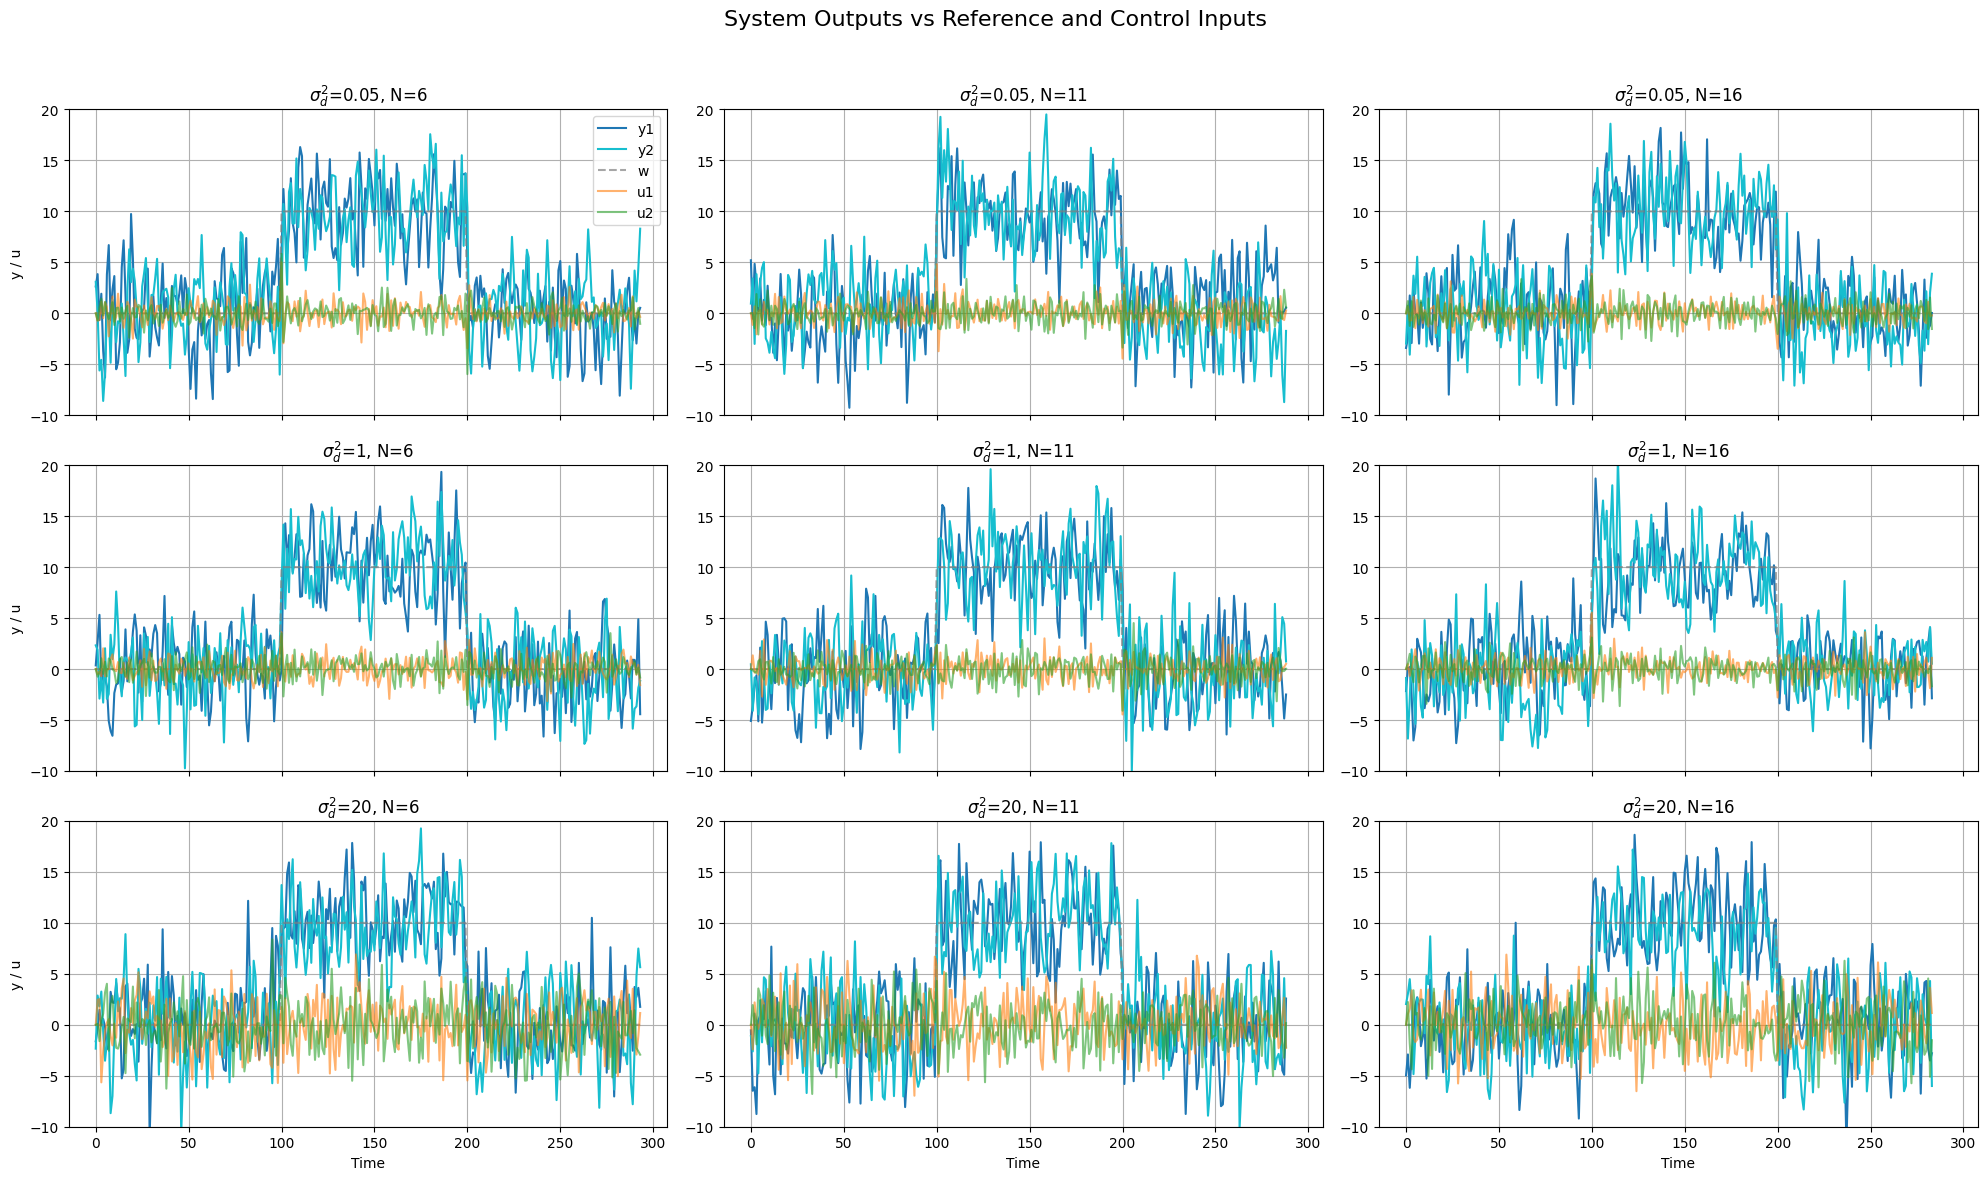

In [69]:
# System definition
x0 = np.zeros((8, 1))

steps = 300

import matplotlib.pyplot as plt

sigma_vals = [0.05, 1, 20]
N_vals = list(range(6, 20, 5))  # [6, 11, 16]
fig, axs = plt.subplots(len(Q_y_vals), len(N_vals), figsize=(20, 12), sharex=True)
fig.suptitle("System Outputs vs Reference and Control Inputs", fontsize=16)
for i, sigma in enumerate(sigma_vals):
    for j, N in enumerate(N_vals):
        Q_13 = np.block([[Q,np.zeros_like(Q)],
                 [np.zeros_like(A),I*sigma]])
        print(f"sigma_d={sigma}, N={N}")

        # Simulation
        kf = Stationary_KalmanFilter(A_13, B_13, C_13, Q_13, R_13, x0)
        x = np.copy(x0)
        x_hist, y_hist, u_hist, w_hist = [], [], [], []

        for t in range(steps - N):
            w = 1.0 * ((t // 100) % 2) * 10
            W = np.tile([[w], [w]], (N, 1))
            U = kf.get_U(x, N, W)
            u_t = U[:2]
            x, y = kf.sim(x, u_t)
            x_hist.append(x.flatten())
            y_hist.append(y.flatten())
            u_hist.append(u_t.flatten())
            w_hist.append([w, w])

        # Convert to arrays
        x_hist = np.array(x_hist)
        y_hist = np.array(y_hist)
        u_hist = np.array(u_hist)
        w_hist = np.array(w_hist)
        T = y_hist.shape[0]

        # Plot both output and input in same subplot
        ax = axs[i, j]
        ax.plot(y_hist[:, 0], label="y1", color='tab:blue')
        ax.plot(y_hist[:, 1], label="y2", color='tab:cyan')
        ax.plot(w_hist[:T, 0], '--', label="w", color='gray', alpha=0.7)
        ax.plot(u_hist[:, 0], label="u1", color='tab:orange', alpha=0.6)
        ax.plot(u_hist[:, 1], label="u2", color='tab:green', alpha=0.6)
        ax.set_title(f"$\\sigma_d^2$={sigma}, N={N}")
        ax.set_ylim(-10,20)
        ax.grid(True)
        if i == len(Q_y_vals)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("y / u")
        if i == 0 and j == 0:
            ax.legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave room for suptitle
plt.savefig('Figures/Question4.png')
plt.show()
